# In Depth: Naive Bayes Classification

In [15]:
plt.style.context('ggplot')

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods. These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$. Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

 $$ P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})} $$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$ \frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)} $$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label. Such a model is called a generative model because it specifies the hypothetical random process that generates the data. Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier. The general version of such a training st

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution. Imagine that you have the following data:

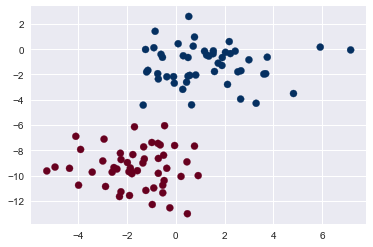

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's sklearn.naive_bayes.GaussianNB estimator:

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [5]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

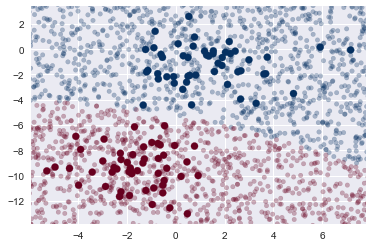

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.3)
plt.axis(lim);


In [8]:
# we can compute using the predict_proba method:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

## Multinomial Naive Bayes

### Example: Classifying Text

In [9]:
from sklearn.datasets import fetch_20newsgroups

# 20 Newsgroups corpus to show how we might classify these short documents into categories
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [10]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [11]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer (discussed in Feature Engineering), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [13]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

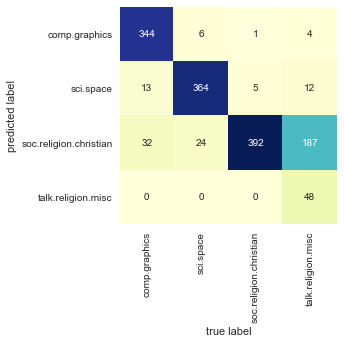

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
           cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [18]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [19]:
predict_category('sending a payload to the ISS')

'sci.space'

In [20]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [21]:
predict_category('determining the screen resolution')

'comp.graphics'

In [29]:
from sklearn.cross_validation import cross_val_score

all_data = fetch_20newsgroups(categories=categories)
scores = cross_val_score(model, all_data.data, all_data.target, cv=10)
print("accuracy: ", scores.mean())

accuracy:  0.8527616768348469


Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:

* They are extremely fast for both training and prediction
* They provide straightforward probabilistic prediction
* They are often very easily interpretable
* They have very few (if any) tunable parameters

Naive Bayes classifiers tend to perform especially well in one of the following situations:

* When the naive assumptions actually match the data (very rare in practice)
* For very well-separated categories, when model complexity is less important
* For very high-dimensional data, when model complexity is less important

